In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)

from pocovidnet import MODEL_FACTORY
from pocovidnet.utils import Metrics

from plots import *
from cross_val_splitter import *
from set_conf_cnn_model import *

### Cargar el dataset

In [2]:
num_folds = 5
data_dir = './image_dataset'
output_dir = './image_cross_val'

In [5]:
import shutil
shutil.rmtree(output_dir)
shutil.rmtree('./trained_models/model_1')

### Dividir el dataset

In [6]:
set_split_crossval = CrossValSplitter(num_folds, data_dir, output_dir)
set_split_crossval.split_dataset()
set_split_crossval.check_crossval(output_dir)

split0 covid 11 131 3
split0 covid 131
split0 regular 5 72 1
split0 regular 72
split1 covid 10 110 3
split1 covid 110
split1 regular 5 64 1
split1 regular 64
split2 covid 12 149 4
split2 covid 149
split2 regular 5 60 1
split2 regular 60
split3 covid 10 160 3
split3 covid 160
split3 regular 5 90 1
split3 regular 90
split4 covid 10 144 3
split4 covid 144
split4 regular 5 46 1
split4 regular 46
El dataset contiene en total 1026 imágenes
split0 covid 11 131 3
split0 covid 131
split0 regular 5 72 1
split0 regular 72
split1 covid 10 110 3
split1 covid 110
split1 regular 5 64 1
split1 regular 64
split2 covid 12 149 4
split2 covid 149
split2 regular 5 60 1
split2 regular 60
split3 covid 10 160 3
split3 covid 160
split3 regular 5 90 1
split3 regular 90
split4 covid 10 144 3
split4 covid 144
split4 regular 5 46 1
split4 regular 46
El dataset contiene en total 1026 imágenes


### Visualización de las clases

In [7]:
classes = ['regular','covid']

In [14]:
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(20,10), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

In [16]:
plots_from_files(covid, rows=5, maintitle="Covid-19 X-ray images")

NameError: name 'covid' is not defined

IndexError: list index out of range

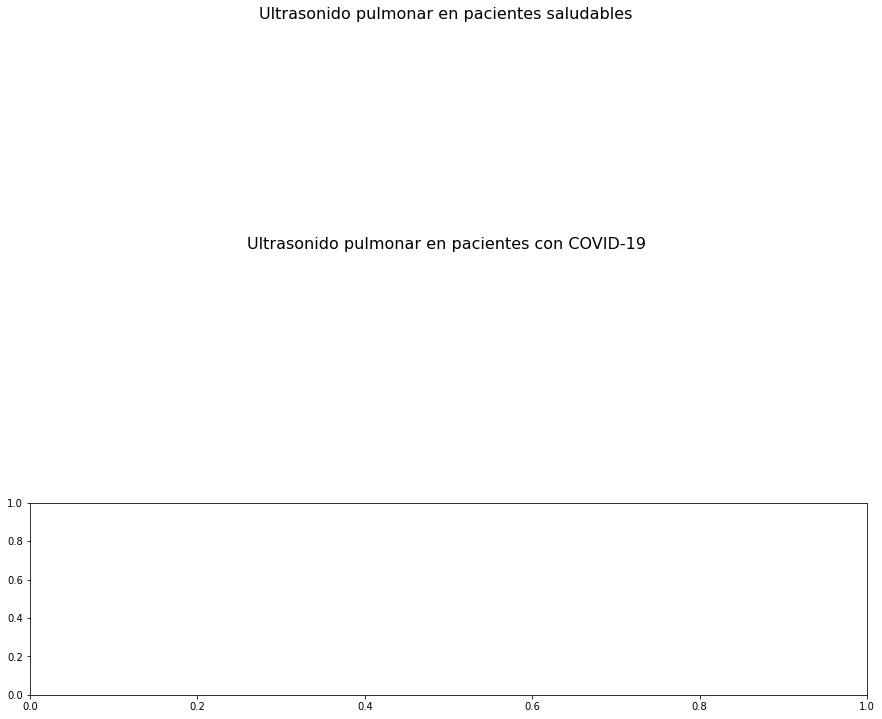

In [10]:
Plots.imgs_dataset(data_dir, classes)

### Definición del modelo

In [17]:
args_model = {
    'data_dir': './image_cross_val',
    'model_name': 'test',
    'model_dir': 'trained_models/model_16',#'models/',
    'model_id': 'vgg_16',
    'fold': 4,
    'learning_rate': 1e-4,
    'epochs': 16,
    'batch_size': 16,
    'trainable_base_layers': 1,
    'img_width': 224,
    'img_height': 224,
    'log_softmax': False,
    'hidden_size': 64
}

In [18]:
vgg_rnn = SetConfModel(args_model)

In [19]:
vgg_rnn.check_model()

Configuración de hiperparámetros:

data_dir: ./image_cross_val
model_name: test
model_dir: trained_models/model_16
model_id: vgg_16
fold: 4
learning_rate: 0.0001
epochs: 16
batch_size: 16
trainable_base_layers: 1
img_width: 224
img_height: 224
log_softmax: False
hidden_size: 64


In [20]:
train_data, test_data, train_labels, test_labels = vgg_rnn.train_test_dataset()

Cargando imágenes...
OK!. 1026 imágenes cargadas
Fold seleccionado: 4

Number of training samples: 836 
Number of testing samples: 190
Total samples: 1026


In [21]:
classes, trainX, testX, trainY, testY = vgg_rnn.one_hot_encoding(train_data, test_data, train_labels, test_labels)

Class mappings are: ['covid' 'regular']


### Aplicando técnicas de regularización

In [22]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
    rotation_range=10,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [23]:
# Load the VGG16 network
model = MODEL_FACTORY[vgg_rnn.MODEL_ID](
    input_size=(vgg_rnn.IMG_WIDTH, vgg_rnn.IMG_HEIGHT, 3),
    num_classes=len(set(train_labels)),
    trainable_layers=vgg_rnn.TRAINABLE_BASE_LAYERS,
    log_softmax=vgg_rnn.LOG_SOFTMAX,
    hidden_size=vgg_rnn.HIDDEN_SIZE
)

### Callbacks

In [ ]:
# Define callbacks
earlyStopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

In [ ]:
mcp_save = ModelCheckpoint(
    os.path.join(vgg_rnn.MODEL_DIR, 'fold_' + str(vgg_rnn.FOLD) + '_epoch_{epoch:02d}'),
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

In [ ]:
reduce_lr_loss = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=7,
    verbose=1,
    epsilon=1e-4,
    #min_delta=1e-4,
    mode='min'
)

In [ ]:
# To show balanced accuracy
metrics = Metrics((testX, testY), model)

In [ ]:
vgg_rnn.compile_model(model)

In [ ]:
H = vgg_rnn.fit_model(model, 
                  trainAug, earlyStopping, mcp_save, reduce_lr_loss, metrics,
                  trainX, testX, trainY, testY)

In [ ]:
# make predictions on the testing set
print('Evaluating network...')
predIdxs = model.predict(testX, batch_size=vgg_rnn.BATCH_SIZE)

In [ ]:
predIdxs_max = np.argmax(predIdxs, axis=1)

print('classification report sklearn:')
print(
    classification_report(
        testY.argmax(axis=1), predIdxs_max, target_names=classes
    )
)

In [ ]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
print('confusion matrix:')
cm = confusion_matrix(testY.argmax(axis=1), predIdxs_max)
# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)

In [ ]:
# serialize the model to disk
print(f'Saving COVID-19 detector model on {vgg_rnn.MODEL_DIR} data...')
model.save(os.path.join(vgg_rnn.MODEL_DIR, 'last_epoch'), save_format='h5')

# plot the training loss and accuracy
Plots.train_loss_acc_results(H, vgg_rnn.MODEL_DIR, vgg_rnn.FOLD, vgg_rnn.EPOCHS)